In [1]:

from utils.audio_dataset_utils import train_val_dataset
from network_models.soundsream_models_and_utils.ss_model_dim_red import SSDimRedModel
from network_models.soundsream_models_and_utils.ss_model_conv import SSConvModel3Sec
from network_models.soundsream_models_and_utils.ss_encoded_dataset import ss_encoded_dataset_full
import torch
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 6

data_set= ss_encoded_dataset_full(csvPath="/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks_clip/content/datasets/soundstream_encoded/allEncodings_noInducednoStimuli_3_5_sec_v12_1_basic.pkl", device=device)

modelDimRed = SSDimRedModel(eval_mode=True).cuda()
modelConv = SSConvModel3Sec(xSize=512, ySize=175, eval_mode=True).cuda()

trainDS, testDs = train_val_dataset(data_set, val_split=0.1, seed=100)
modelConv.load_state_dict(torch.load("/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/soundstream/experiments_final/Run_Nr_0/conv/emo_reco_best_ep149_acc_73.pth"))
modelDimRed.load_state_dict(torch.load("/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/soundstream/experiments_final/Run_Nr_0/dimred/emo_reco_best_ep563_acc_69.pth"))

#modelEncoder = SSBottelneckLayer(num_cols = 175,bottleneck_size =  4, dropout=0, train_mode=False).cuda()
#modelEncoder.load_state_dict(torch.load("/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/soundstream/experiments/AUTO_encoder/Nr2_25001/encoder_1500.pth"))

2023-03-23 15:03:11.076218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 15:03:11.644371: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-23 15:03:11.644430: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-23 15:03:11.644434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

<All keys matched successfully>

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from numpy import ndarray
json_path ="/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/data/dimension_eval/"

def generateParameters(device, model, dataset, labels, encoder = False):
    loader = DataLoader(dataset, shuffle=False, batch_size=batch_size)
    d ={}

    for label in labels:
        d.update({label: []})

    with torch.no_grad():
        for batch, (X, z) in enumerate(loader):
            X, z = X.to(device),  z.to(device)
            if(encoder):
                X = torch.flatten(X, 1)
            dims, pred = model(X, return_with_dims= True)
            label = data_set.encoded_dataset.label_list[z[0].nonzero().cpu().numpy()[0][0]]
            dims = dims.cpu().numpy()[0]
            d[label].append(dims)
            if batch % 500 == 0:
                print(f"{batch*batch_size} of {len(dataset)}")
    return d

def genAvgAndVarByLabel(data: list[ndarray[float]], labelList):
    d = pd.DataFrame()
    for label in labelList:
        mean = np.round(np.asarray(data[label]).mean(keepdims=True, axis=0), 2)
        var = np.round(np.asarray(data[label]).var(keepdims=True, axis=0), 2)
        d[label] = pd.Series([mean[0], var[0]], index=["mean", "var"])
        #d.update({label : pd.Series([mean, var], index=["mean", "var"])})
        #d.update({label : pd.Series([mean, var], index=["mean", "var"])})

    return d

def genAvgFullByLabel(fulldata: list[dict], label_list, modelNameList):
    fullDict = {}
    for model in range(len(modelNameList)):
        fullDict.update({modelNameList[model]: genAvgAndVarByLabel(fulldata[model], label_list)})
    return fullDict

def genAvgAndVar(data: list[list[ndarray[float]]], modelNameList):
    d = {}
    for i in range(len(modelNameList)):
        mean = np.mean(np.asarray(data[i]), axis=0)
        var = np.var(np.asarray(data[i]), axis=0)
        d.update({modelNameList[i] : pd.Series([mean, var], index=["mean", "var"])})
    return d

def genAvgFull(fulldata: list[dict], label_list, modelNameList):
    fullDict = {}
    for label in label_list:
        fullDict.update({label: genAvgAndVar([fd[label] for fd in fulldata], modelNameList)})
    return fullDict

def write_latex(fileName, string):
    Path(json_path).mkdir(parents=True, exist_ok=True)
    print(f"writing: {string} \n to {json_path+fileName}.txt")
    file = open(json_path+f"{fileName}.txt", "w")
    file.write(string)
    file.close()

In [3]:
arra = generateParameters("cuda", modelConv, data_set, data_set.encoded_dataset.label_list)

arra_dr = generateParameters("cuda", modelDimRed, data_set, data_set.encoded_dataset.label_list)

#arra_enc  = generateParameters("cuda", modelEncoder, testDs, data_set.encoded_dataset.label_list, encoder=True)


0 of 6092
3000 of 6092
6000 of 6092
0 of 6092
3000 of 6092
6000 of 6092


In [6]:
asaa["conv"]

,angry,disgust,fear,happy,neutral,sad,surprise
mean,"[0.96, 0.96, 0.92, 0.86]","[-0.89, -0.85, -0.9, -0.9]","[0.9, -0.93, 0.89, 0.89]","[-0.96, -0.96, 0.93, -0.92]","[-0.91, 0.91, -0.98, 0.3]","[0.47, 0.82, -0.89, 0.88]","[-0.94, -0.94, 0.85, 0.95]"
var,"[0.07, 0.05, 0.11, 0.16]","[0.15, 0.15, 0.13, 0.14]","[0.12, 0.07, 0.08, 0.11]","[0.04, 0.04, 0.06, 0.12]","[0.04, 0.08, 0.01, 0.06]","[0.14, 0.21, 0.12, 0.17]","[0.04, 0.07, 0.1, 0.06]"


In [4]:
#asaa = pd.DataFrame(genAvgFull([arra, arra_dr], data_set.encoded_dataset.label_list ,["conv", "dimred"]))
asaa = genAvgFullByLabel([arra, arra_dr], data_set.encoded_dataset.label_list ,["conv", "dimred"])

write_latex("conv_mean_var" ,asaa["conv"].T.to_latex(float_format="{{:0.2f}}"))
write_latex("dimred_mean_var" ,asaa["dimred"].T.to_latex(float_format="{{:0.2f}}"))
#asaa["conv"].to_latex()

writing: \begin{tabular}{lll}
\toprule
{} &                         mean &                       var \\
\midrule
angry    &     [0.96, 0.96, 0.92, 0.86] &  [0.07, 0.05, 0.11, 0.16] \\
disgust  &   [-0.89, -0.85, -0.9, -0.9] &  [0.15, 0.15, 0.13, 0.14] \\
fear     &     [0.9, -0.93, 0.89, 0.89] &  [0.12, 0.07, 0.08, 0.11] \\
happy    &  [-0.96, -0.96, 0.93, -0.92] &  [0.04, 0.04, 0.06, 0.12] \\
neutral  &    [-0.91, 0.91, -0.98, 0.3] &  [0.04, 0.08, 0.01, 0.06] \\
sad      &    [0.47, 0.82, -0.89, 0.88] &  [0.14, 0.21, 0.12, 0.17] \\
surprise &   [-0.94, -0.94, 0.85, 0.95] &   [0.04, 0.07, 0.1, 0.06] \\
\bottomrule
\end{tabular}
 
 to /home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/data/dimension_eval/conv_mean_var.txt
writing: \begin{tabular}{lll}
\toprule
{} &                          mean &                       var \\
\midrule
angry    &     [-0.32, 0.73, 0.72, 0.81] &  [0.13, 0.22, 0.22, 0.08] \\
disgust  &    [-0.87, 0.6, -0.48, -0.17] &  [0.0

/tmp/ipykernel_223677/886858928.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  write_latex("conv_mean_var" ,asaa["conv"].T.to_latex(float_format="{{:0.2f}}"))
/tmp/ipykernel_223677/886858928.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  write_latex("dimred_mean_var" ,asaa["dimred"].T.to_latex(float_format="{{:0.2f}}"))


In [14]:
from utils.utils__evalutation import show_bars
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns



def show_bars_local(predictions, label_list, color="r", title_string =""):

    show_bars(predictions, label_list, color, title_string)



AttributeError: 'dict' object has no attribute 'shape'

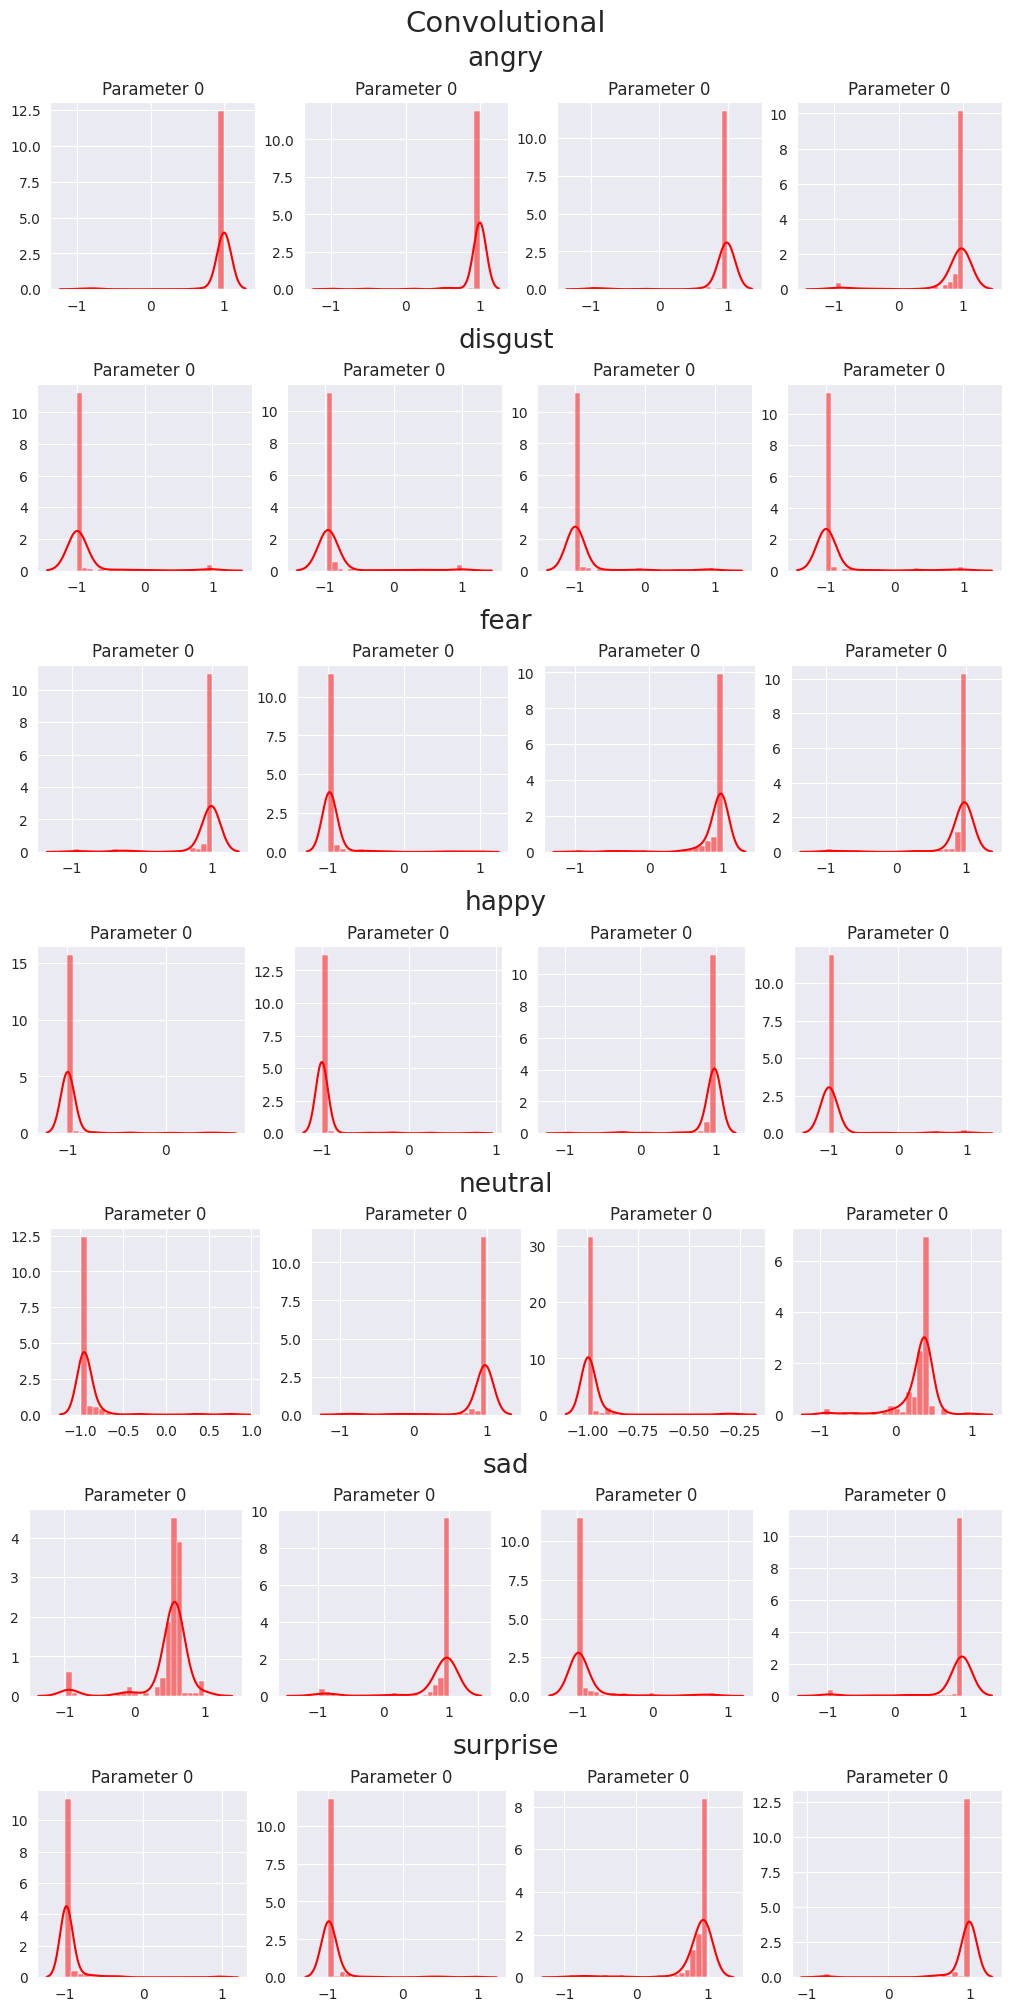

In [18]:

show_bars_local(arra, data_set.encoded_dataset.label_list, color="r", title_string="Convolutional")